## This model an LSTM with UMLSBERT as encoder feature encoder from https://github.com/gmichalo/UmlsBERT used for classfication of the entities in 43 STY labels

Here we initialize the TPU environment

In [1]:
import tensorflow as tf
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Import necessary packages

- Version of tensorflow is 2.4.1
- If the version of tensorflow is differnet, this might cause errors later in the training

In [2]:
%%capture

!pip install seqeval

import json
import csv

from tqdm import tqdm


import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Input, Bidirectional, Dense, LSTM, TimeDistributed, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K

from seqeval.metrics import classification_report, f1_score, accuracy_score
from seqeval.metrics.sequence_labeling import get_entities
from seqeval.scheme import IOB2

from transformers import BertTokenizer as BertTokenizer1
from transformers import TFBertModel as TFBertModel1
from transformers import BertConfig as BertConfig1

## Build Data

- We import the data from the text files we obtained from the article https://arxiv.org/abs/2006.05281, 

- We build lists for labels, sequences

In [3]:
def reformat_data(data_file):
    with open(data_file, 'r') as file:
        article_sentences, article_labels = [], []
        sentence_tokens, sentence_labels = [], []
        
        for line in file.readlines():
            if line == '\n':
                if sentence_labels != []:
                    article_sentences.append(sentence_tokens)
                    article_labels.append(sentence_labels)
                    sentence_tokens, sentence_labels = [], []
            else:
                token = line.split(" ")[0]
                label = line.split(" ")[1][:-1]
                sentence_tokens.append(token)
                sentence_labels.append(label)
        
        article_sentences.append(sentence_tokens)
        article_labels.append(sentence_labels)
                
    return article_sentences, article_labels
    
train_sentences, train_recog_labels = reformat_data("../input/thesis/st21pv_training_and_validation.txt")
test_sentences, test_recog_labels = reformat_data("../input/thesis/st21pv_testing.txt")

We build a label dictionary in order to tokenize the labels, each label maps to a unique number

In [4]:
label_dict = {}
i = -1
for sent_labels in train_recog_labels:
    for label in sent_labels:
        if label not in label_dict.keys():
            i+=1
            label_dict[label] = i 
            
label_dict

{'O': 0,
 'B-biologic_function': 1,
 'I-biologic_function': 2,
 'B-chemical': 3,
 'B-anatomical_structure': 4,
 'B-eukaryote': 5,
 'B-spatial_concept': 6,
 'B-research_activity': 7,
 'I-spatial_concept': 8,
 'I-chemical': 9,
 'B-intellectual_product': 10,
 'B-virus': 11,
 'I-virus': 12,
 'B-body_substance': 13,
 'B-health_care_activity': 14,
 'I-health_care_activity': 15,
 'B-population_group': 16,
 'I-research_activity': 17,
 'I-intellectual_product': 18,
 'B-professional_or_occupational_group': 19,
 'I-professional_or_occupational_group': 20,
 'B-organization': 21,
 'I-anatomical_structure': 22,
 'B-medical_device': 23,
 'I-medical_device': 24,
 'B-biomedical_occupation_or_discipline': 25,
 'I-population_group': 26,
 'B-finding': 27,
 'I-finding': 28,
 'B-clinical_attribute': 29,
 'I-clinical_attribute': 30,
 'I-body_substance': 31,
 'I-organization': 32,
 'I-eukaryote': 33,
 'B-bacterium': 34,
 'I-bacterium': 35,
 'B-injury_or_poisoning': 36,
 'I-injury_or_poisoning': 37,
 'I-biomed

## UMLSBERT Tokenizer

In [5]:
%%capture
!wget -O umlsbert.tar.xz https://www.dropbox.com/s/qaoq5gfen69xdcc/umlsbert.tar.xz?dl=0
#!git clone https://huggingface.co/cambridgeltl/SapBERT-from-PubMedBERT-fulltext/
!tar -xvf umlsbert.tar.xz

umlsbert_tokenizer = BertTokenizer1.from_pretrained('./umlsbert/', do_lower_case=True)

In [6]:
umlsbert_tokenizer

PreTrainedTokenizer(name_or_path='./umlsbert/', vocab_size=28996, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

We add [CLS] and [SEP] in order for the model to know the sentence borders

In [7]:
for i, sample_sent in enumerate(train_sentences):
    marked_sent = ["[CLS]"]
    marked_sent.extend(sample_sent)
    marked_sent.append("[SEP]")
    train_sentences[i] = marked_sent

for i, sample_sent in enumerate(test_sentences):
    marked_sent = ["[CLS]"]
    marked_sent.extend(sample_sent)
    marked_sent.append("[SEP]")
    test_sentences[i] = marked_sent

We here consider the labels of [SEP] and [CLS] as 'O' 

In [8]:
for i, labels in enumerate(train_recog_labels):
    marked_labels = ["O"]
    marked_labels.extend(labels)
    marked_labels.append("O")
    train_recog_labels[i] = marked_labels

for i, labels in enumerate(test_recog_labels):
    marked_labels = ["O"]
    marked_labels.extend(labels)
    marked_labels.append("O")
    test_recog_labels[i] = marked_labels

This is to tokenize the word into subwords (UMLSBERT tokenization) while saving the labels (This breaks the label of each word and repeat it to each subword).

In [9]:
def tokenize_and_preserve_labels(sentence, recog_labels):
    tokenized_sentence = []
    rec_labels = []
    masks = []
    
    for word, recog_label in zip(sentence, recog_labels):

        tokenized_word = umlsbert_tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)
        if n_subwords <= 1:
            rec_labels.extend([recog_label]*n_subwords)
            masks.extend([1]*n_subwords)
        else:
            rec_labels.extend([recog_label]+["O"]*(n_subwords-1))
            masks.extend([1]+[0]*(n_subwords-1))
    return tokenized_sentence, rec_labels, masks

In [10]:
tokenized_train_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(tqdm(train_sentences), train_recog_labels)
]
tokenized_test_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(tqdm(test_sentences), test_recog_labels)
]

100%|██████████| 8687/8687 [00:22<00:00, 386.54it/s]


In [11]:
tokenized_train_texts = [token_label_pair[0] for token_label_pair in tokenized_train_texts_and_labels]
train_recog_labels = [token_label_pair[1] for token_label_pair in tokenized_train_texts_and_labels]
tokenized_test_texts = [token_label_pair[0] for token_label_pair in tokenized_test_texts_and_labels]
test_recog_labels = [token_label_pair[1] for token_label_pair in tokenized_test_texts_and_labels]
train_masks = [token_label_pair[2] for token_label_pair in tokenized_train_texts_and_labels]
test_masks = [token_label_pair[2] for token_label_pair in tokenized_test_texts_and_labels]

## Padding

We pad the masks, sequences, labels to the maximum length of the sequences

In [12]:
def text_stats():
    tokens_dict = {}
    lengths = []
    i = 0
    for txt in [tokenized_test_texts_and_labels, tokenized_train_texts_and_labels]:
        for sentence in txt:
            lengths.append(len(sentence[0]))
            for word in np.unique(sentence[0]):
                if word.lower() not in tokens_dict.keys():
                    i+=1
                    tokens_dict[word.lower()] = i
                    
    return tokens_dict, np.max(lengths)
            
tokens_dict, maxlen = text_stats()

print("Maximum length of the sentences after breaking words into subwords is: ", maxlen)

Maximum length of the sentences after breaking words into subwords is:  311


In [13]:
train_ids = sequence.pad_sequences([umlsbert_tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_train_texts],
                          maxlen=maxlen, dtype="long", value=0.0,
                          truncating="post", padding="post")

train_labels = sequence.pad_sequences([[label_dict.get(l) for l in lab] for lab in train_recog_labels], 
                             maxlen=maxlen, value=0.0, padding="post", 
                             dtype="long", truncating="post")

test_ids = sequence.pad_sequences([umlsbert_tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_texts],
                          maxlen=maxlen, dtype="long", value=0.0,
                          truncating="post", padding="post")

test_labels = sequence.pad_sequences([[label_dict.get(l) for l in lab] for lab in test_recog_labels],
                     maxlen=maxlen, value=0.0, padding="post",
                     dtype="long", truncating="post")

test_mask = sequence.pad_sequences([[l for l in lab] for lab in test_masks],
                     maxlen=maxlen, value=label_dict["O"], padding="post",
                     dtype="long", truncating="post")

train_mask = sequence.pad_sequences([[l for l in lab] for lab in train_masks], 
                             maxlen=maxlen, value=label_dict["O"], padding="post", 
                             dtype="long", truncating="post")

Here we convert labels into one hot encoding matrix

In [14]:
train_labels_ohe = [to_categorical(i, num_classes=len(label_dict)) for i in train_labels]
test_labels_ohe = [to_categorical(i, num_classes=len(label_dict)) for i in test_labels]

Cast sequences into tensors

In [15]:
train_seq = train_ids
test_seq = test_ids
train_seq = tf.cast(train_seq, tf.float32) 
test_seq = tf.cast(test_seq, tf.float32)
train_labels = tf.cast(train_labels_ohe, tf.float32)
test_labels = tf.cast(test_labels_ohe, tf.float32)
train_mask = tf.cast(train_mask, tf.float32)
test_mask = tf.cast(test_mask, tf.float32)

In [16]:
print(train_seq.shape)
print(train_mask.shape)
print(train_labels.shape)
print(test_seq.shape)
print(test_mask.shape)
print(test_labels.shape)

(34830, 311)
(34830, 311)
(34830, 311, 43)
(8687, 311)
(8687, 311)
(8687, 311, 43)


## Evaluation matrics

Here we mask the 'O' tags from the labels, the same mask location is excluded from the ground truth and prediction tensor

In [17]:
def mask(m, q):
    mask = tf.math.reduce_any(tf.not_equal(m, q), axis=-1)
    return mask

def recall(y_true, y_pred):
    pad = tf.constant([1]+[0 for i in range(len(label_dict)-1)], dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_true = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_true * masked_y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(masked_y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    pad = tf.constant([1]+[0 for i in range(len(label_dict)-1)], dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_true = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_true * masked_y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(masked_y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

## LSTM Network

In [29]:
def build_bert_lstm_model():
    config = BertConfig1.from_json_file('./umlsbert/config.json')
    config.output_hidden_states=True
    encoder = TFBertModel1.from_pretrained("./umlsbert/", from_pt=True, name='UMLSBert', config=config)
    encoder.bert.trainable = False

    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="Input Ids")
    mask = Input(shape=(maxlen,), dtype=tf.int32, name="Input Mask")
    outputs = encoder(input_ids, attention_mask=mask)
    
    #  get last four layers
    last_four_layers = [outputs.hidden_states[i] for i in (-1, -2, -3, -4)]
    # sum them element wise
    sum_hidden_states = tf.math.add_n(last_four_layers)
    # take the mean of the vector 
    avg_emb = tf.math.scalar_mul(1/4, sum_hidden_states)
    #concat_emb = tf.concat(last_four_layers, axis=-1)
    
    outputs = Bidirectional(LSTM(units=128, return_sequences=True, 
                                 dropout=0.4, recurrent_dropout=0.4), 
                            merge_mode = 'concat', name='Bi-LSTM')(avg_emb)
    
    outputs = LSTM(units=256, dropout=0.4,  return_sequences=True, 
                   recurrent_dropout=0.4, name='LSTM')(outputs)
    
    outputs = (TimeDistributed(Dense(128, activation="relu"), 
                               name='TimeDistributed'))(outputs)

    outputs = (Dense(len(label_dict), activation="softmax", 
                     name='Output-Layer'))(outputs)

    bert_lstm = Model([input_ids, mask], outputs)
    
    bert_lstm.compile(loss="CategoricalCrossentropy",
                      metrics=[f1, precision, recall], 
                      optimizer=tf.keras.optimizers.Adam(0.0008))
    
    return bert_lstm

Here we build validation data for each cross validation by slicing the original train data in order to provide different validation data for each KFold

In [33]:
tf.random.set_seed(42)
val_history = {}
for k_fold in tqdm(range(3)):
    X_val, mask_val, y_val = (train_seq[k_fold*10000:k_fold*10000+10000], 
                                    train_mask[k_fold*10000:k_fold*10000+10000], 
                                    train_labels[k_fold*10000:k_fold*10000+10000])
    
    if k_fold == 0:
        X_train, mask_train, y_train = (train_seq[k_fold*10000+10000:], 
                                  train_mask[k_fold*10000+10000:], 
                                  train_labels[k_fold*10000+10000:])
    else:
        X_train, mask_train, y_train = (tf.concat([train_seq[:k_fold*10000], train_seq[k_fold*10000+10000:]], axis=0), 
                                        tf.concat([train_mask[:k_fold*10000], train_mask[k_fold*10000+10000:]], axis=0),
                                        tf.concat([train_labels[:k_fold*10000], train_labels[k_fold*10000+10000:]], axis=0))

    with tpu_strategy.scope(): 
        bert_lstm_model = build_bert_lstm_model()
        #bert_lstm_model.summary()
        val_history["bert_lstm_his{0}".format(k_fold)] = bert_lstm_model.fit((X_train, mask_train), y_train, 
                                        epochs = 30 , batch_size = 64, 
                                        validation_data = ((X_val, mask_val), y_val))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/30
388/388 [==============================] - 97s 162ms/step - loss: 0.2715 - f1: 1.0202e-04 - precision: 2.0810e-04 - recall: 6.8382e-05 - val_loss: 0.0820 - val_f1: 0.0307 - val_precision: 0.0785 - val_recall: 0.0196
Epoch 2/30
388/388 [==============================] - 46s 118ms/step - loss: 0.0798 - f1: 0.0654 - precision: 0.1186 - recall: 0.0459 - val_loss: 0.0638 - val_f1: 0.2198 - val_precision: 0.3448 - val_recall: 0.1646
Epoch 3/30
388/388 [==============================] - 46s 117ms/step - loss: 0.0663 - f1: 0.2054 - precision: 0.3251 - recall: 0.1519 - val_loss: 0.0584 - val_f1: 0.3414 - val_precision: 0.4965 - val_recall: 0.2648
Epoch 4/30
388/388 [==============================] - 46s 118ms/step - loss: 0.0603 - f1: 0.2746 - precision: 0.4046 - recall: 0.2102 - val_loss: 0.0554 - val_f1: 0.3994 - val_precision: 0.5346 - val_recall: 0.3238
Epoch 5/30
388/388 [==============================] - 46s 118ms/step - loss: 0.0563 - f1: 0.3246 - precision: 0.4588 - recall: 0

 33%|███▎      | 1/3 [23:54<47:48, 1434.43s/it]

Epoch 1/30
388/388 [==============================] - 97s 162ms/step - loss: 0.3023 - f1: 1.6243e-05 - precision: 3.3143e-05 - recall: 1.0892e-05 - val_loss: 0.0842 - val_f1: 0.0118 - val_precision: 0.0310 - val_recall: 0.0074
Epoch 2/30
388/388 [==============================] - 46s 118ms/step - loss: 0.0834 - f1: 0.0427 - precision: 0.0777 - recall: 0.0300 - val_loss: 0.0632 - val_f1: 0.2360 - val_precision: 0.3566 - val_recall: 0.1802
Epoch 3/30
388/388 [==============================] - 46s 118ms/step - loss: 0.0664 - f1: 0.2064 - precision: 0.3212 - recall: 0.1538 - val_loss: 0.0574 - val_f1: 0.3526 - val_precision: 0.5047 - val_recall: 0.2764
Epoch 4/30
388/388 [==============================] - 46s 118ms/step - loss: 0.0604 - f1: 0.2800 - precision: 0.4073 - recall: 0.2155 - val_loss: 0.0540 - val_f1: 0.3903 - val_precision: 0.5231 - val_recall: 0.3161
Epoch 5/30
388/388 [==============================] - 46s 118ms/step - loss: 0.0565 - f1: 0.3233 - precision: 0.4536 - recall: 0

 67%|██████▋   | 2/3 [47:56<23:58, 1438.67s/it]

Epoch 1/30
388/388 [==============================] - 98s 163ms/step - loss: 0.2810 - f1: 3.5589e-05 - precision: 7.2893e-05 - recall: 2.3896e-05 - val_loss: 0.0847 - val_f1: 0.0060 - val_precision: 0.0142 - val_recall: 0.0039
Epoch 2/30
388/388 [==============================] - 46s 117ms/step - loss: 0.0818 - f1: 0.0471 - precision: 0.0844 - recall: 0.0332 - val_loss: 0.0659 - val_f1: 0.2325 - val_precision: 0.3667 - val_recall: 0.1740
Epoch 3/30
388/388 [==============================] - 46s 118ms/step - loss: 0.0673 - f1: 0.1856 - precision: 0.2940 - recall: 0.1372 - val_loss: 0.0598 - val_f1: 0.3329 - val_precision: 0.4958 - val_recall: 0.2562
Epoch 4/30
388/388 [==============================] - 46s 118ms/step - loss: 0.0605 - f1: 0.2632 - precision: 0.3903 - recall: 0.2008 - val_loss: 0.0551 - val_f1: 0.3645 - val_precision: 0.4933 - val_recall: 0.2936
Epoch 5/30
388/388 [==============================] - 46s 118ms/step - loss: 0.0567 - f1: 0.3087 - precision: 0.4414 - recall: 0

100%|██████████| 3/3 [1:11:58<00:00, 1439.61s/it]


In [34]:
loss_plot = [[val_history["bert_lstm_his"+str(i)].history['loss'] for i in range(3)], 'Training Loss']
f1_plot = [[val_history["bert_lstm_his"+str(i)].history['f1'] for i in range(3)], 'Training F1']
val_loss_plot = [[val_history["bert_lstm_his"+str(i)].history['val_loss'] for i in range(3)], 'Validation Loss']
val_f1_plot = [[val_history["bert_lstm_his"+str(i)].history['val_f1'] for i in range(3)], 'Validation F1']
val_precision_plot = [[val_history["bert_lstm_his"+str(i)].history['val_precision'] for i in range(3)], 'Validation Precision']
precision_plot = [[val_history["bert_lstm_his"+str(i)].history['precision'] for i in range(3)], 'Training Precision']
recall_plot = [[val_history["bert_lstm_his"+str(i)].history['recall'] for i in range(3)], 'Training Recall']
val_recall_plot = [[val_history["bert_lstm_his"+str(i)].history['val_recall'] for i in range(3)], 'Validation Recall']

In [35]:
import math
import matplotlib.pyplot as plt
def make_plot(metric, val_metric, ylabel):
    epochs = range(1, 31)
    xint = range(min(epochs)+1, math.ceil(max(epochs))+1, 2)

    plt.figure(figsize=(25,15))
    plt.plot(epochs, metric[0][0],  label=metric[1], linewidth=4, c="#0000FF", )
    plt.plot(epochs, val_metric[0][0], label=val_metric[1], linewidth=4, c="#FFA500")
    plt.plot(epochs, metric[0][1],  linewidth=4, c="#0000FF", )
    plt.plot(epochs, val_metric[0][1], linewidth=4, c="#FFA500")
    plt.plot(epochs, metric[0][2],  linewidth=4, c="#0000FF", )
    plt.plot(epochs, val_metric[0][2],  linewidth=4, c="#FFA500")
    plt.xlabel('Epochs', fontsize=50)
    plt.ylabel(ylabel, fontsize=50)
    plt.legend(fontsize=50)
    plt.xticks(xint, fontsize=50)
    plt.yticks(fontsize=50)
    plt.grid()
    plt.tight_layout()
    plt.savefig(metric[1]+'.pdf')
    plt.show()

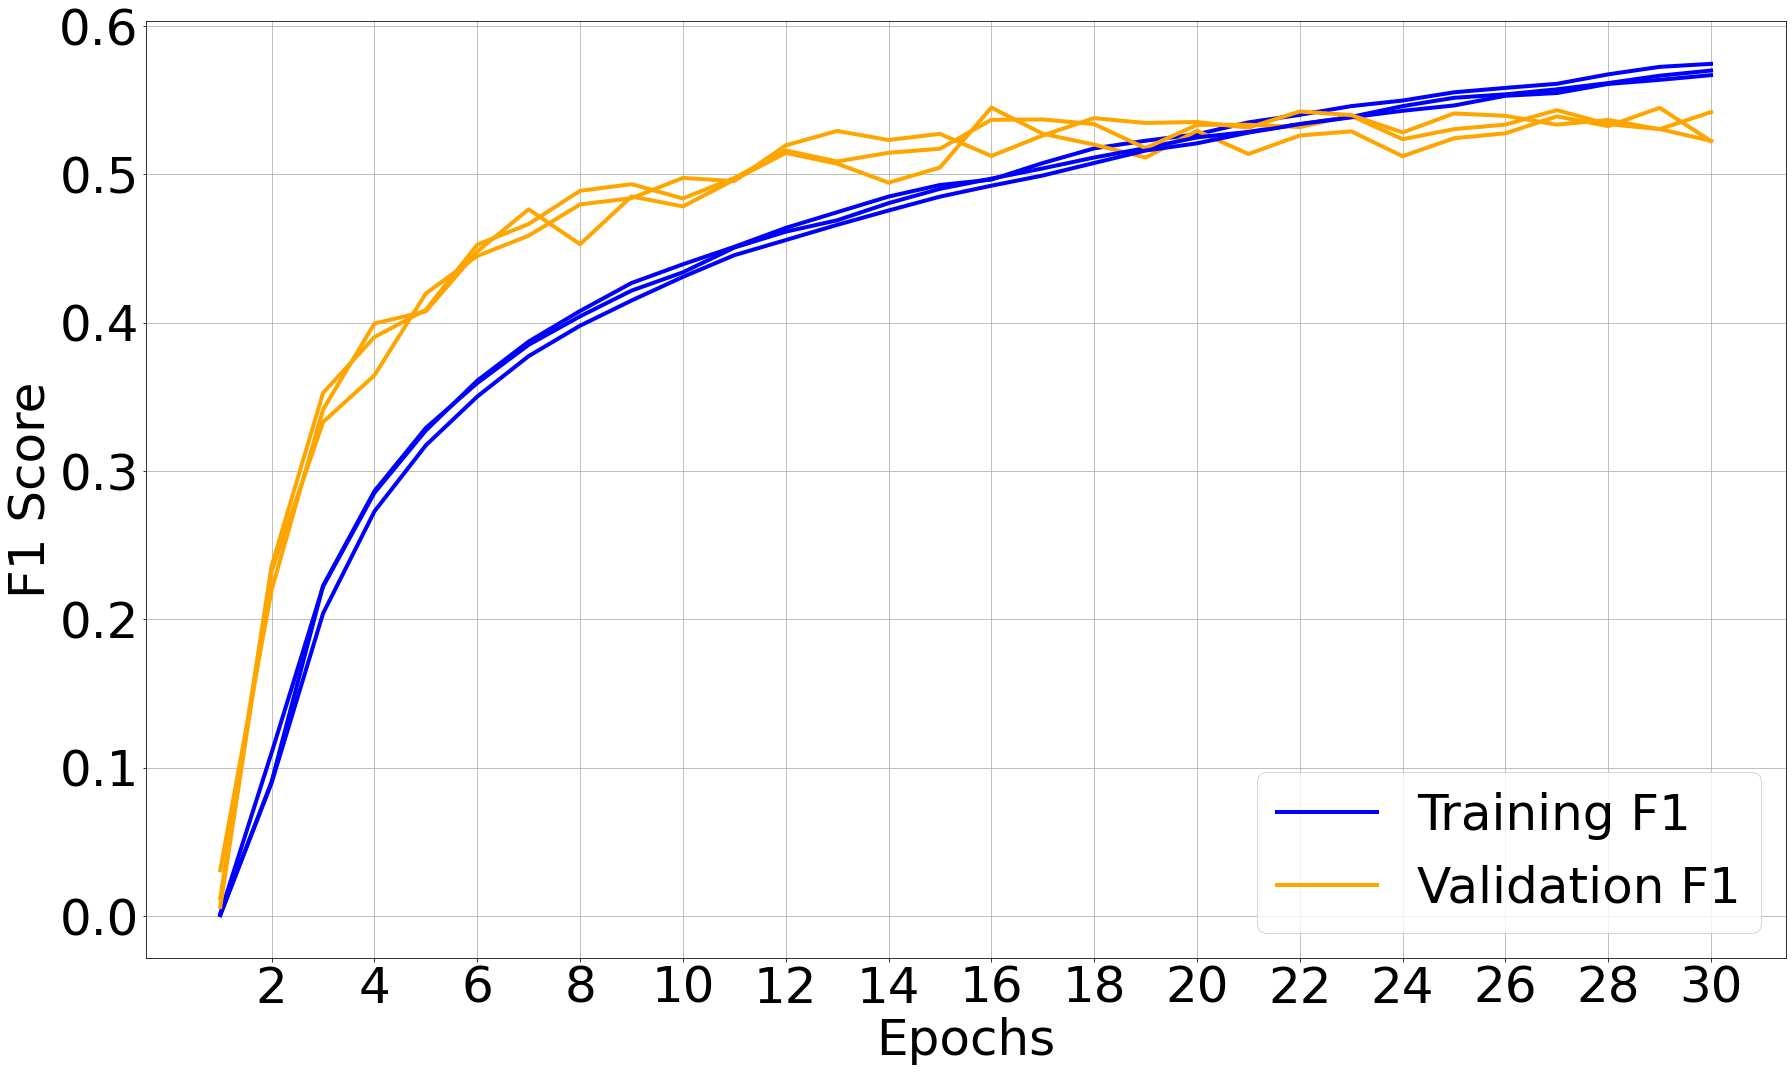

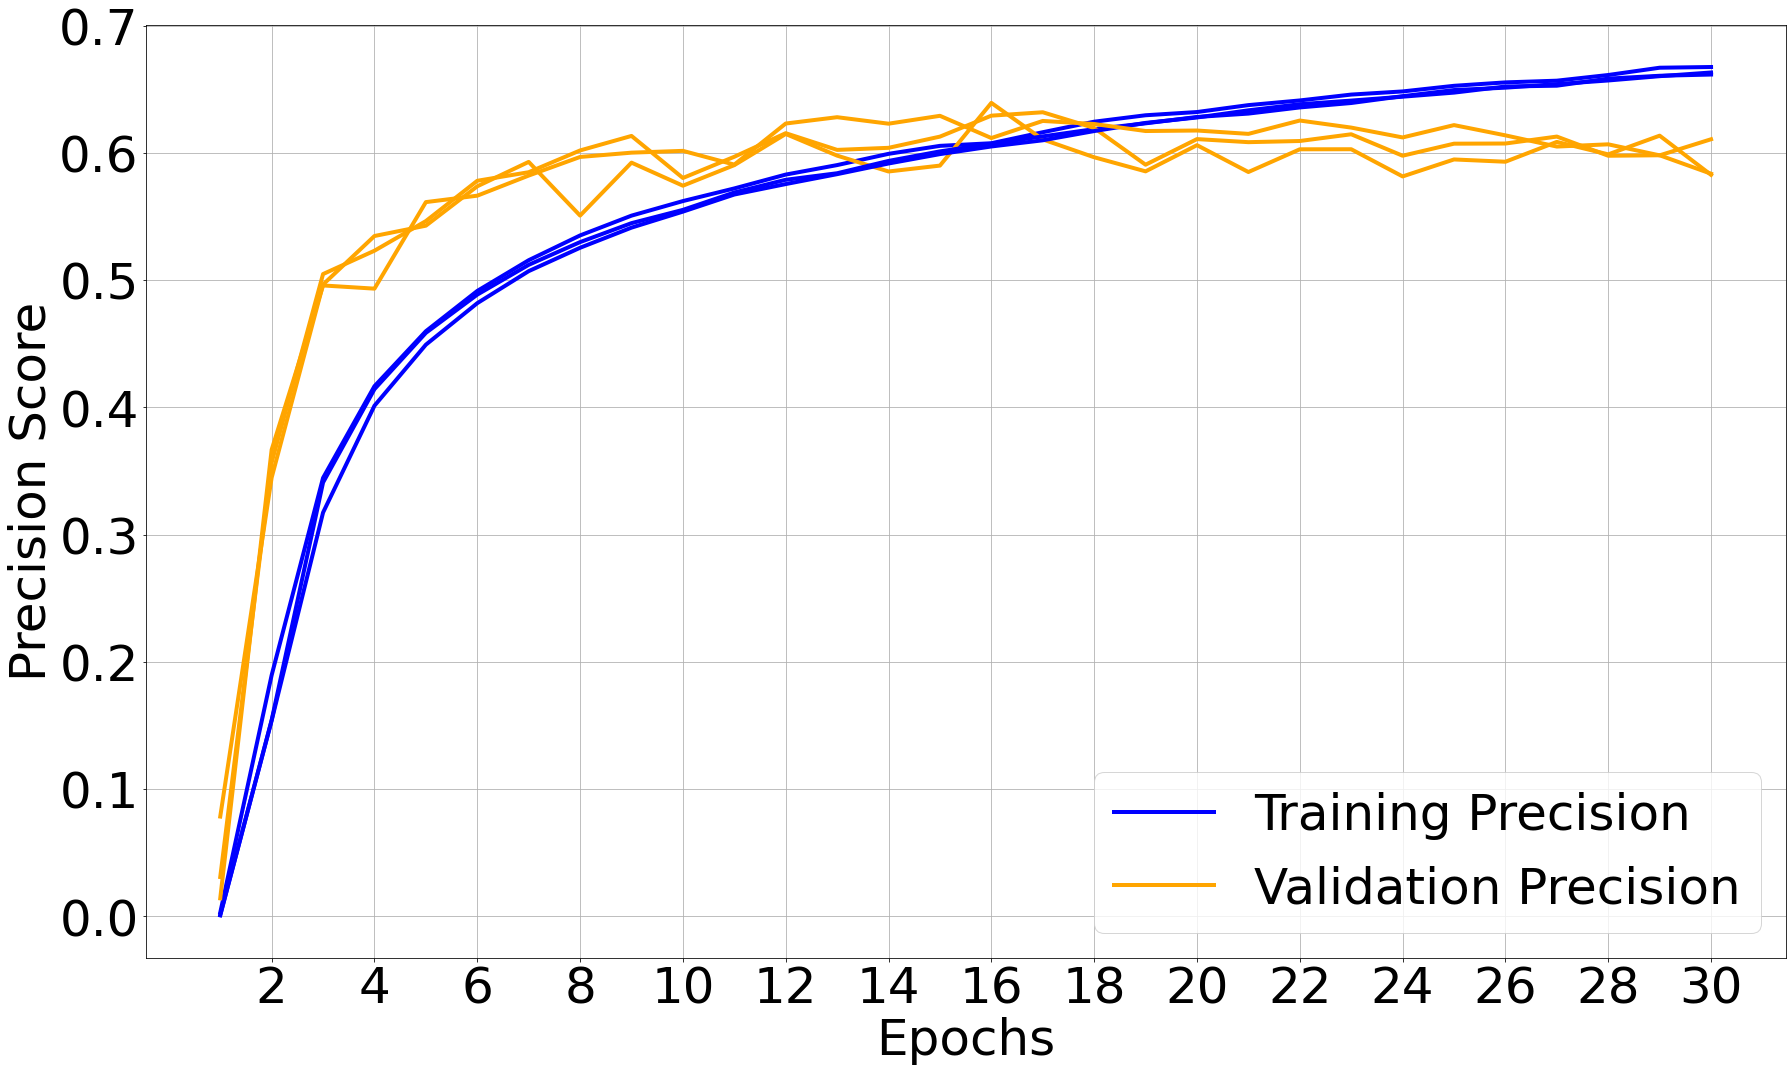

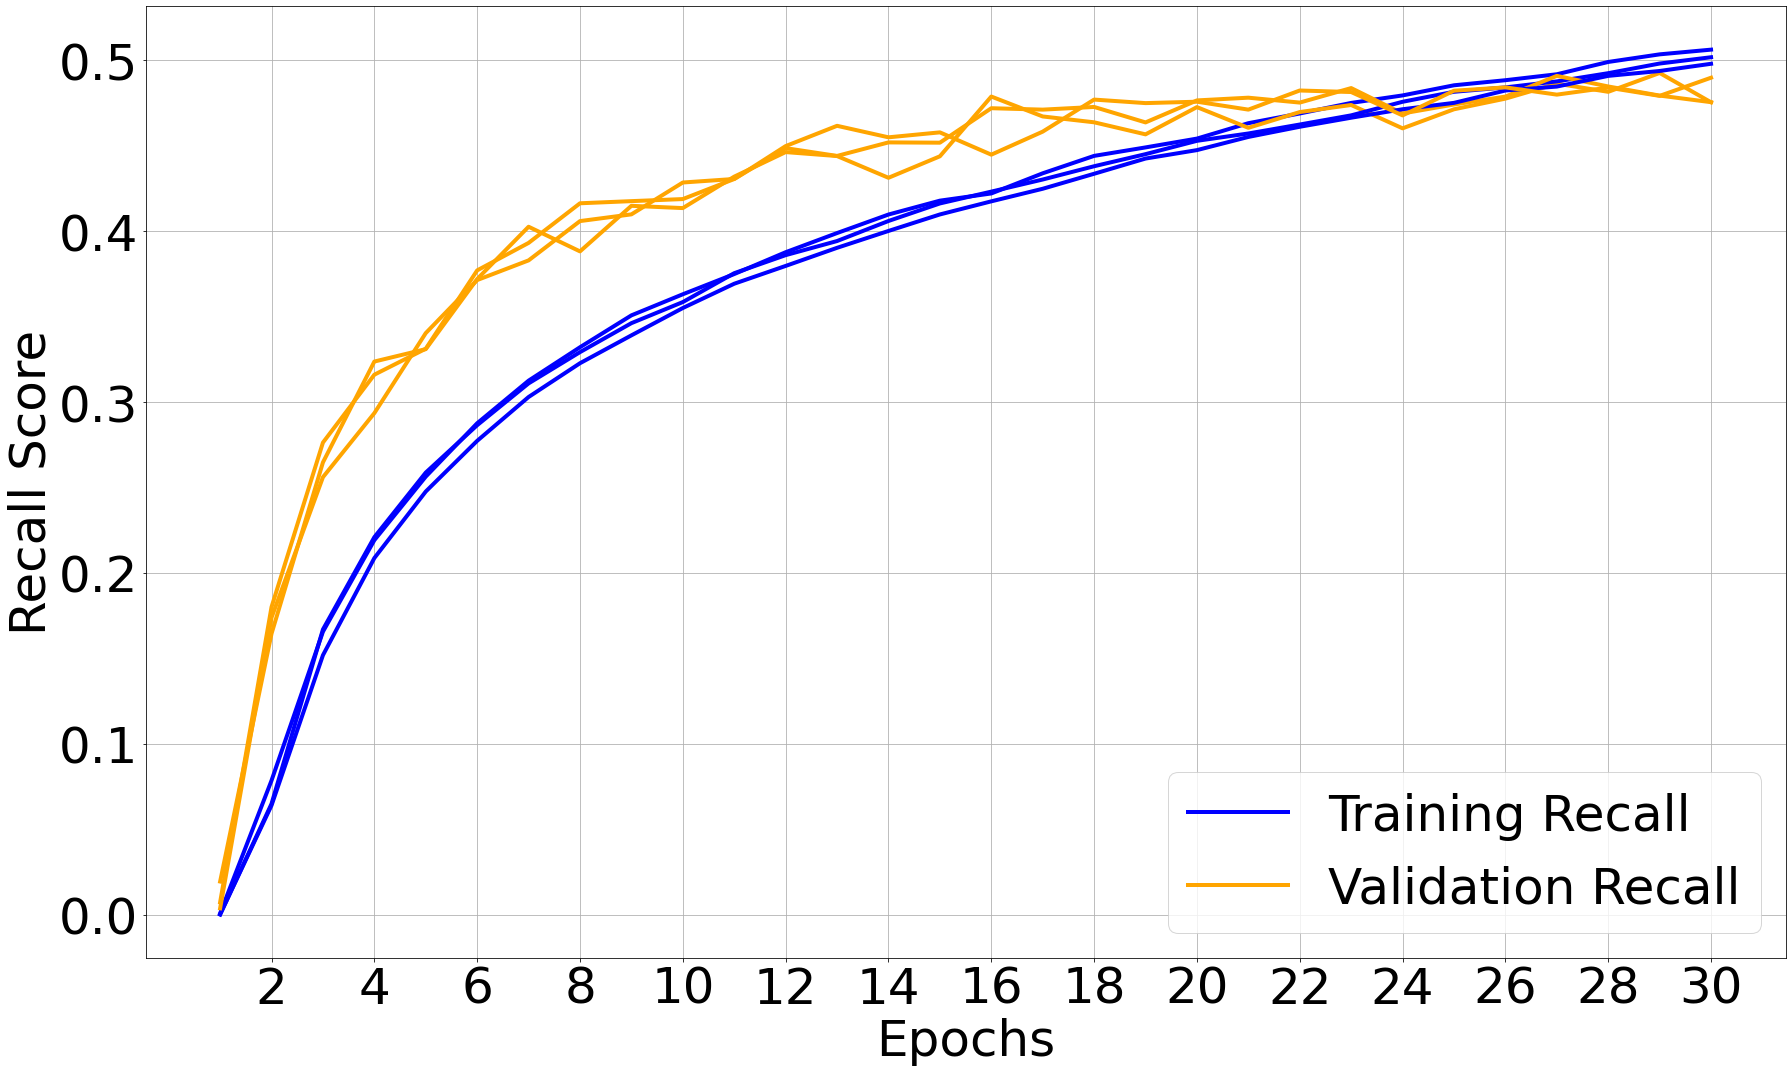

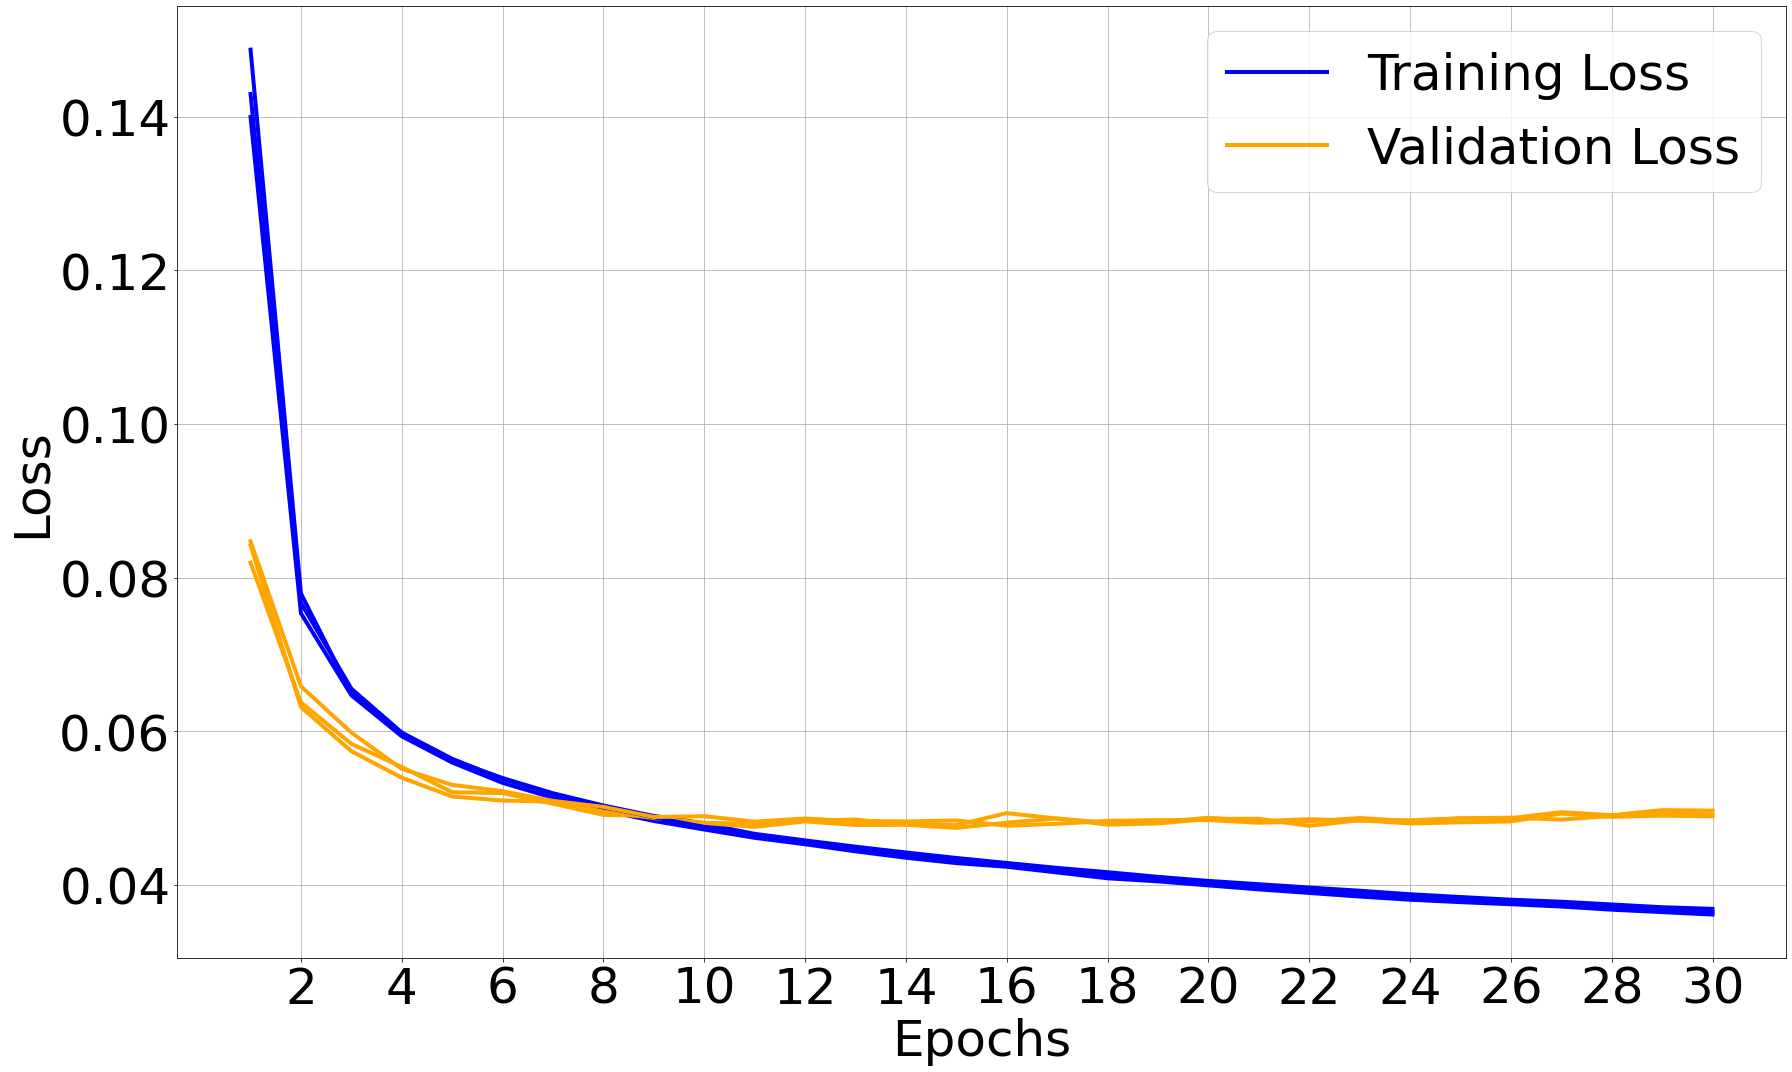

In [36]:
make_plot(f1_plot, val_f1_plot, 'F1 Score')
make_plot(precision_plot, val_precision_plot, 'Precision Score')
make_plot(recall_plot, val_recall_plot, 'Recall Score')
make_plot(loss_plot, val_loss_plot, 'Loss')

After knowing that the optimal epoch is 27, we train the full model on the entire train data

In [54]:
tf.random.set_seed(42)

with tpu_strategy.scope(): 
    final_bert_lstm_model = build_bert_lstm_model()

In [55]:
final_bert_lstm_model.fit((train_seq, train_mask), train_labels, epochs=27, batch_size=64, verbose=0)

This is used to save the original labels after detokenizing them using inverse dictionary of the tokenization dictionary above

In [56]:
inv_label_map = {v: k for k, v in label_dict.items()}

In [58]:
final_bert_lstm_model.evaluate((test_seq, test_mask), test_labels)

272/272 [==============================] - 28s 61ms/step - loss: 0.0458 - f1: 0.5486 - precision: 0.6213 - recall: 0.4968


[0.04583977907896042,
 0.5485814809799194,
 0.621260404586792,
 0.49675852060317993]

In [59]:
test_pred = np.array(final_bert_lstm_model.predict((test_seq, test_mask)))
example_sentence = test_sentences[2021]
example_tokens = umlsbert_tokenizer.convert_ids_to_tokens(test_seq[2021])
example_mask = test_mask[2021]
example_gold = np.argmax(test_labels[2021], axis=-1)
example_pred = np.argmax(test_pred[2021], axis=-1)

def merge_subwords(sent_tokens, sent_pred, sent_gold):
    new_tokens, gold_labels, predicted_labels = [], [], []
    for token, label_hat, label in zip(sent_tokens, sent_pred, sent_gold):
        if token != "[PAD]":
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                predicted_labels.append(inv_label_map[label_hat])
                gold_labels.append(inv_label_map[label])
                new_tokens.append(token)
    return new_tokens, gold_labels, predicted_labels

new_tokens, gold_labels, predicted_labels = merge_subwords(example_tokens, example_pred, example_gold)

print("{0:35} {1:40} {2:40}".format('Token', 'Gold', 'Prediction'))
print("{0:35} {1:40} {2:40}".format('_____', '____', '__________'))

for token, label_hat, label in zip(new_tokens, gold_labels, predicted_labels):
    print("{0:35} {1:40} {2:40}".format(token, label_hat, label))  

Token                               Gold                                     Prediction                              
_____                               ____                                     __________                              
[CLS]                               O                                        O                                       
in                                  O                                        O                                       
fact                                O                                        O                                       
,                                   O                                        O                                       
both                                O                                        O                                       
the                                 O                                        O                                       
resistive                           O                   

## Merging word pieces

this is done by merging word pieces that begin with "##" with the previous word pieces

In [60]:
def merge_subwords(sent_tokens, sent_rec_pred, sent_rec_gold, sent_rec_pred_prob):
    new_tokens, gold_rec_labels, predicted_rec_labels, predicted_rec_probs = [], [], [], []
    for token, pred_rec_label, gold_rec_label, pred_rec_prob in zip(sent_tokens, 
                                                                    sent_rec_pred, 
                                                                    sent_rec_gold,
                                                                    sent_rec_pred_prob):
        if token != "[PAD]":
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                predicted_rec_labels.append(inv_label_map[pred_rec_label])
                gold_rec_labels.append(inv_label_map[gold_rec_label])
                predicted_rec_probs.append(pred_rec_prob)
                new_tokens.append(token)
                
    return new_tokens, predicted_rec_labels, gold_rec_labels, predicted_rec_probs

Saving the entire test data groundtruth and predictions with softmax probability into alist

In [61]:
test_pred = np.argmax(final_bert_lstm_model.predict((test_seq, test_mask)), axis=-1)
test_prob = np.max(final_bert_lstm_model.predict((test_seq, test_mask)), axis=-1)
test_true = np.argmax(test_labels, axis=-1)

test_seq_predictions = []
for seq, seq_rec_pred, seq_rec_gold, prob in zip(tqdm(test_seq), test_pred, test_true, test_prob):
    seq = umlsbert_tokenizer.convert_ids_to_tokens(seq)
    test_seq_predictions.append(merge_subwords(seq, seq_rec_pred, seq_rec_gold, prob))

100%|██████████| 8687/8687 [1:12:14<00:00,  2.00it/s]


Saving the portion train data (first 3000 samples) groundtruth and predictions with softmax probability into alist

In [62]:
train_pred = np.argmax(final_bert_lstm_model.predict((train_seq, train_mask)), axis=-1)
train_prob = np.max(final_bert_lstm_model.predict((train_seq, train_mask)), axis=-1)
train_true = np.argmax(train_labels, axis=-1)

(train_seq_portion, 
 train_pred_portion, 
 train_true_portion, 
 train_prob_portion) = (
    train_seq[:3000], 
    train_pred[:3000], 
    train_true[:3000], 
    train_prob[:3000])

train_seq_predictions = []
for seq, seq_rec_pred, seq_rec_gold, prob  in zip(tqdm(train_seq_portion), train_pred_portion, train_true_portion, train_prob_portion):
    seq = umlsbert_tokenizer.convert_ids_to_tokens(seq)
    train_seq_predictions.append(merge_subwords(seq, seq_rec_pred, seq_rec_gold, prob))

100%|██████████| 3000/3000 [25:07<00:00,  1.99it/s]


Saving test data and portion of train data into csv

In [63]:
def extract_rows(predictions):
    rows = []
    for seq, seq_rec_pred, seq_rec_gold, prob in predictions:
        for entity, pred_label, gold_label, pred_prob in zip(seq, seq_rec_pred, seq_rec_gold, prob):
            rows.append([entity, pred_label, gold_label, pred_prob])
    return rows

test_rows = extract_rows(test_seq_predictions)
train_rows = extract_rows(train_seq_predictions)

In [64]:
def save_csv(rows, name):
    fields = ['Tokens', 'Pred Label', 'Gold Label', 'Pred Prob']     
    with open(name+'.csv', 'w') as f: 
        write = csv.writer(f) 
        write.writerow(fields) 
        write.writerows(rows) 

save_csv(test_rows, 'test_rec_prediction_lstm_umlsbert')
save_csv(train_rows, 'train_rec_prediction_lstm_umlsbert')